In [1]:
import numpy as np
import os
import math
import sys
import csv
import itertools

from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from tqdm import tqdm
from enum import Enum
from typing import Optional
from r3m import load_r3m
import clip

import torch
import torch.nn as nn
import torch.multiprocessing as mp
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage, InterpolationMode

import matplotlib.pyplot as plt
import pandas as pd

from torch.nn import functional as nnf
import wandb

from dataset import CustomDataset, AttrDict 
from utils.visualize import visualize, showImages
from utils.beamsearch import beamsearch
from models.caption_model import ClipCaptionModel, MappingType

import config as CFG


mp.set_start_method('spawn')


/home/tim/anaconda3/envs/cap-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-10 21:57:20.614500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualize Calvin Data

In [ ]:
visualize()

In [ ]:
datapath_test= '.././test_data/D_D/task_D_D_episode.npz'
data = np.load(datapath_test)
print(list(data.keys()))
print(data['actions'].shape)
print(data['rel_actions'].shape)
print(data['rgb_static'].shape)
print(data['rgb_gripper'].shape)
print(data['scene_obs'])

## Captioning

find sutiable caption for optimization

In [ ]:
path = CFG.datapath_training_parsed + "/lang_annotations/auto_lang_ann.npy"

annotations = np.load(path, allow_pickle=True).item()
annotations = annotations["language"]["ann"]


unique, counts = np.unique(annotations, return_counts=True)
print(dict(zip(unique, counts)))

### Data Loader

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

datapath_training_parsed = CFG.datapath_training_parsed
datapath_val_parsed = CFG.datapath_val_parsed
caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_training_parsed)
caption_path_val = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_val_parsed)

# train_dataset = CustomDataset(datapath_dd_training, caption_path_training, tokenizer, max_seq_length)
observation_data = 'static_and_gripper'
train_dataset = CustomDataset(datapath_training_parsed, caption_path_training, tokenizer, CFG.max_seq_length, observation_data)
val_dataset  = CustomDataset(datapath_val_parsed, caption_path_val, tokenizer, CFG.max_seq_length, observation_data)

train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)



Test Data Loader

In [ ]:
caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_training_parsed)
annotations = np.load(f"{caption_path_training}", allow_pickle=True).item()
annotations = list(zip(annotations["info"]["indx"], annotations["language"]["ann"]))
annotations[1]

In [ ]:
for idx, batch in enumerate(val_dataloader):
    if os.name == 'nt': 
        os.system('cls')
    else:
        os.system('clear')

    print("gpt_tokens: ", batch.gpt_tokens.shape)
    print("gpt_mask: ", batch.gpt_mask.shape)
    print(batch.instruction[0])
    print(list(zip(batch.caption_index[0].tolist(), batch.caption_index[1].tolist()))[0])
    print("actions: ", batch.actions.shape)
    print("observations: ", batch.observations.shape)
    print("batch at index done: ", idx)
    break


In [ ]:

clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text
clip_text_features = clip_text_encoder(clip.tokenize("grasp the blue block, then rotate it left").to(CFG.device))   #.detach().cpu().numpy()[()].squeeze(0)

print(clip_text_features.shape)

## Training

In [ ]:
def validate(model: ClipCaptionModel):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in tqdm(val_dataloader):

            data.observations = data.observations.to(CFG.device)
            data.actions = data.actions.to(CFG.device)
            # data.instruction = data.instruction.to(CFG.device)
            # data.instruction = (clip_text_encoder(clip.tokenize(data.instruction).to(CFG.device)).detach().cpu().numpy()).to(CFG.device)
            data.instruction = clip_text_encoder(clip.tokenize(data.instruction).to(CFG.device)).to(CFG.device)
            data.gpt_tokens = data.gpt_tokens.to(CFG.device)
            data.gpt_mask = data.gpt_mask.to(CFG.device)
            outputs = model(data)

            logits = outputs.logits[:, data.observations.shape[1] - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), data.gpt_tokens.flatten(), ignore_index=0)
            
            total_loss += loss.item()

    return total_loss / len(val_dataloader)

def train(model: ClipCaptionModel,
          lr: float = 2e-5, warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = ""):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    epochs = CFG.epochs
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)

    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )

    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for idx, data in enumerate(train_dataloader):

            model.zero_grad()

            data.observations = data.observations.to(CFG.device)
            data.actions = data.actions.to(CFG.device)
            data.instruction = clip_text_encoder(clip.tokenize(data.instruction).to(CFG.device)).to(CFG.device)
            data.gpt_tokens = data.gpt_tokens.to(CFG.device)
            data.gpt_mask = data.gpt_mask.to(CFG.device)
            
            outputs = model(data)


            logits = outputs.logits[:, data.observations.shape[1] - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), data.gpt_tokens.flatten(), ignore_index=0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            wandb.log({"loss": loss.item()})
            progress.update()
            if (idx+1) % 20 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                )
                # val_loss = validate(model)
                # wandb.log({"val_loss": val_loss})
        progress.close()
        if epoch % 1 == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
    return model

### Load and Train Model

In [ ]:
wandb.init(project="clipcalvin")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

prefix_length = 10
prefix_length_clip = 10
num_layers = 8
prefix_dim = 512
mapping_type = {'mlp': MappingType.MLP, 'transformer': MappingType.Transformer}["transformer"]

model = ClipCaptionModel(prefix_length, clip_length=prefix_length_clip, prefix_size=prefix_dim,
                          num_layers=num_layers, mapping_type=mapping_type)


clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

train(model, output_dir="./checkpoints/hulccap/run_4_rgb_gripper_and_static", output_prefix="hulccap_prefix")


## Evaluation

### find best model and write losses to csv

In [ ]:
clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 


def evaluate_loss(path, filename, dataloader):

    mapper_model = ClipCaptionModel(prefix_length=10, clip_length=10).to(CFG.device)
    mapper_model.load_state_dict(torch.load(path, map_location=CFG.device))
    mapper_model = mapper_model.eval()

    total_loss = 0
    for data in dataloader:

        data.observations = data.observations.to(CFG.device)
        data.actions = data.actions.to(CFG.device)
        data.instruction = clip_text_encoder(clip.tokenize(data.instruction).to(CFG.device)).to(CFG.device)
        data.gpt_tokens = data.gpt_tokens.to(CFG.device)
        data.gpt_mask = data.gpt_mask.to(CFG.device)

        outputs = mapper_model(data)

        with torch.no_grad():
            logits = outputs.logits[:, data.observations.shape[1] - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), data.gpt_tokens.flatten(), ignore_index=0)    
            total_loss += loss.item()
    return total_loss  / len(dataloader)

        

#model_dir = "./checkpoints/hulccap/run_1/"
model_dir = "./checkpoints/hulccap/run2_with_stoptoken/"
csv_filepath = "./results/static_loss.csv"
#model_dir = "./checkpoints/hulccap/run_3_rgb_gripper/"
#csv_filepath = "./results/gripper_loss.csv"
#model_dir = "./checkpoints/hulccap/run_4_rgb_gripper_and_static/"
#csv_filepath = "./results/gripper_and_static_loss.csv"


best_model = None
best_loss = float('inf')
results = []

for filename in os.listdir(model_dir):
    epoch = filename[-6:-3]
    try:
        epoch_ = int(epoch)
        print(epoch)
        model_path = os.path.join(model_dir, filename)
        val_loss = evaluate_loss(model_path, filename, val_dataloader)
        train_loss = evaluate_loss(model_path, filename, train_dataloader)
        print(filename, ' val_loss: ', val_loss, ' train_loss: ', train_loss)
        results.append({'epoch': epoch, 'filename': filename,  'val_loss': val_loss, 'train_loss': train_loss})
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = filename
    except:
        print("error getting epoch number")

print("best model: ", best_model, ' loss: ', best_loss)
results.sort(key=lambda x: x['epoch'])

with open(csv_filepath, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['epoch', 'filename', 'val_loss', 'train_loss'])
    writer.writeheader()
    for result in results:
        writer.writerow(result)
    
print("wrote results to ", csv_filepath)

### Plot losses

In [ ]:
csv_folder = "./results/"

for filename in os.listdir(csv_folder):
    csv_filepath = os.path.join(csv_folder, filename)

    loss_data = pd.read_csv(csv_filepath)
    epochs = loss_data['epoch']
    val_loss = loss_data['val_loss']
    train_loss = loss_data['train_loss']

    val_loss = np.log(val_loss)
    train_loss = np.log(train_loss)

    plt.plot(epochs, val_loss, label='Validation Loss', marker='.')
    plt.plot(epochs, train_loss, label='Training Loss', marker='.')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    title = 'Loss Over Epochs for: ' + csv_filepath
    plt.title(title)
    plt.legend()
    plt.show()

    best_val_loss = float('inf')
    best_epoch = 0
    for epoch, val_loss in enumerate(loss_data['val_loss']):
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
    print("best loss for ", csv_filepath, " for epoch ", best_epoch, ": ", best_val_loss)


for filename in os.listdir(csv_folder):
    csv_filepath = os.path.join(csv_folder, filename)
    loss_data = pd.read_csv(csv_filepath)
    epochs = loss_data['epoch']
    val_loss = loss_data['val_loss']
    val_loss = np.log(val_loss)
    plt.plot(epochs, val_loss, label=filename, marker='.')

plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
title = 'comapre validation loss'
plt.title(title)
plt.legend()
plt.show()


for filename in os.listdir(csv_folder):
    csv_filepath = os.path.join(csv_folder, filename)
    loss_data = pd.read_csv(csv_filepath)
    epochs = loss_data['epoch']
    train_loss = loss_data['train_loss']
    val_loss = np.log(train_loss)
    plt.plot(epochs, val_loss, label=filename, marker='.')

plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
title = 'comapre train loss'
plt.title(title)
plt.legend()
plt.show()

### Evaluate best model

Greedy decoding

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# path_best = "./checkpoints/hulccap/run_1/hulccap_prefix-032.pt"
path_best = "./checkpoints/hulccap/run2_with_stoptoken/hulccap_prefix-028.pt"
best_model = ClipCaptionModel(prefix_length=10, clip_length=10).to(CFG.device)
best_model.load_state_dict(torch.load(path_best, map_location=CFG.device))
best_model = best_model.eval()

for data in val_dataloader:

    instruction_ground = data.instruction

    data.observations = data.observations.to(CFG.device)
    data.actions = data.actions.to(CFG.device)
    data.gpt_tokens = data.gpt_tokens.to(CFG.device)
    data.gpt_mask = data.gpt_mask.to(CFG.device)

    outputs = best_model(data)
    
    for i in range(len(data.instruction)):
        print("INSTRUCTION:", instruction_ground[i])
        

        with torch.no_grad():
            generated_token = outputs.logits[i].argmax(dim=-1)
            print(outputs.logits[i].shape)
            print(generated_token.shape)

            # remove duplicates
            result = []
            for i in range(len(generated_token)):
                word = generated_token[i]
                if word not in result or result[-1] != word:
                    result.append(word)
            result_tensor = torch.tensor(result)

            generated_text = tokenizer.decode(result_tensor)
            print("Generated Caption:", generated_text)

    break

Beam decoding

INSTRUCTION GROUND: turn on the green light 
  at index:  [tensor([35722]), tensor([35764])]
[('push down the button to turn on the led light \n', tensor(0.7979, device='cuda:0')), ('push down the button to turn on the green light \n', tensor(0.7883, device='cuda:0')), ('push the button to turn on the led light \n', tensor(0.7786, device='cuda:0')), ('turn on the led light \n', tensor(0.7694, device='cuda:0')), ('turn on the led lamp \n', tensor(0.7353, device='cuda:0'))]


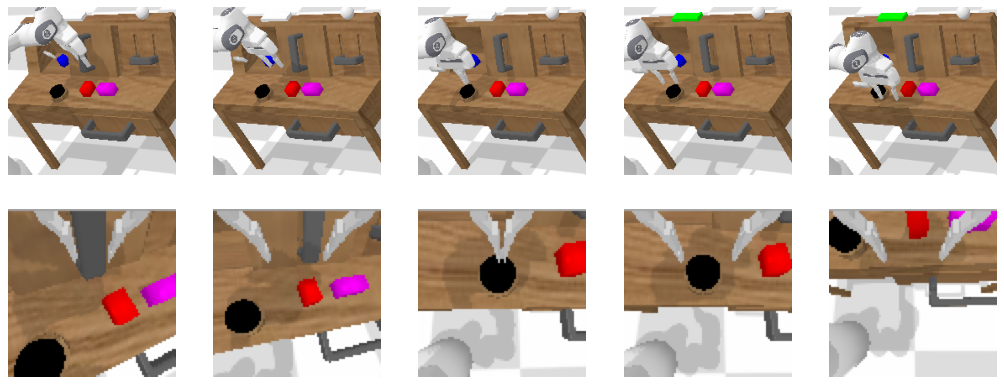

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=CFG.num_workers)

clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

#path_best = "./checkpoints/hulccap/run_1/hulccap_prefix-032.pt"
#path_best = "./checkpoints/hulccap/run2_with_stoptoken/hulccap_prefix-028.pt"
path_best = "./checkpoints/hulccap/run_4_rgb_gripper_and_static/hulccap_prefix-029.pt"

best_model = ClipCaptionModel(prefix_length=10, clip_length=10).to(CFG.device)
best_model.load_state_dict(torch.load(path_best, map_location=CFG.device))
# best_model = best_model.eval()

for data in itertools.islice(val_dataloader, 0, 1):

    instruction_ground = data.instruction
    index_ground = data.caption_index

    data.observations = data.observations.to(CFG.device)
    data.actions = data.actions.to(CFG.device)
    data.gpt_tokens = data.gpt_tokens.to(CFG.device)
    data.gpt_mask = data.gpt_mask.to(CFG.device)

    for i in range(len(data.instruction)):
        print("INSTRUCTION GROUND:", instruction_ground[i], " at index: ", index_ground)  
        # print(data.observations.shape)
        src = AttrDict(observations=data.observations, actions=data.actions)
        behaviour_encoding = best_model.behaviour_encoder(src)
        prefix_embed = best_model.project_to_gpt(behaviour_encoding)
        generated_caption =  beamsearch(best_model, tokenizer, prefix_embed)
        print(generated_caption)
        showImages(index_ground[0].item(), CFG.datapath_val)

### Generate new caption using beam and sliding window 

find lowest and highest episode

In [4]:
datafiles = os.listdir(CFG.datapath_training_parsed)

indices = next(iter(np.load(f"{CFG.datapath_training}/scene_info.npy", allow_pickle=True).item().values()))
print(indices)

lowest = float('inf')
highest = float('-inf')
# Loop through and print the file names
for file in datafiles:
    try:
        epi_num = file.split('_')[1].split('.')[0]
        epi_num = int(epi_num)
        if epi_num < lowest:
            lowest = epi_num
        if epi_num > highest:
            highest = epi_num
    except:
         print(f"Skipping '{file}'")

print("lowest episode: ",lowest)
print("highest episode: ",highest)

[0, 611098]
Skipping 'lang_annotations'
lowest episode:  53819
highest episode:  611098


[('grasp the handle of the drawer and open it \n', tensor(0.8584, device='cuda:0')), ('grasp the handle of the drawer, then open it \n', tensor(0.8439, device='cuda:0')), ('pull the handle of the drawer \n', tensor(0.7723, device='cuda:0')), ('open the drawer \n', tensor(0.7356, device='cuda:0')), ('open the cabinet drawer \n', tensor(0.7047, device='cuda:0'))]


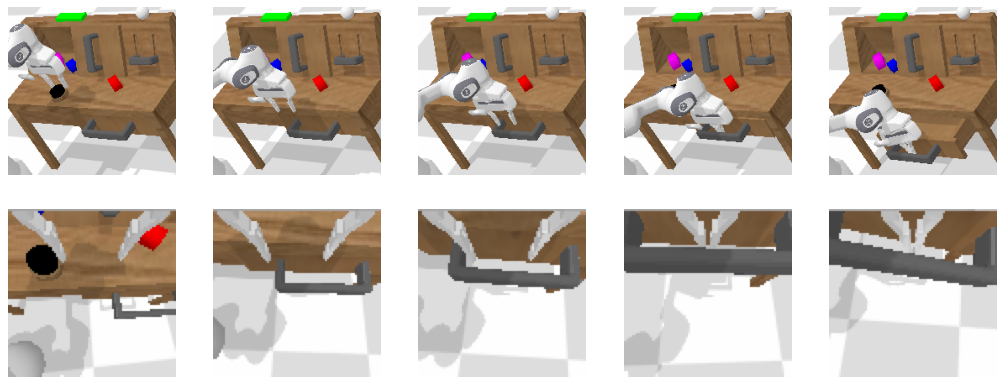

[('grasp the handle of the drawer, then close it \n', tensor(0.8549, device='cuda:0')), ('grasp the handle of the drawer and close it \n', tensor(0.8120, device='cuda:0')), ('grasp the drawer handle, then close it \n', tensor(0.7887, device='cuda:0')), ('grasp the drawer handle and close it \n', tensor(0.7762, device='cuda:0')), ('close the cabinet drawer \n', tensor(0.6999, device='cuda:0'))]


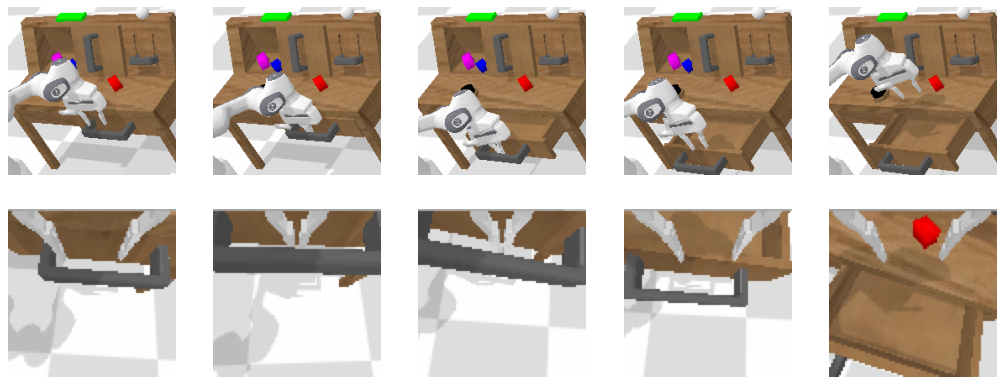

[('move the door all the way to the left and let go \n', tensor(0.9082, device='cuda:0')), ('move the door to the left side \n', tensor(0.8035, device='cuda:0')), ('slide the door to the left side \n', tensor(0.7799, device='cuda:0')), ('push the door to the left side \n', tensor(0.7522, device='cuda:0')), ('move the door all the way to the left \n', tensor(0.7364, device='cuda:0'))]


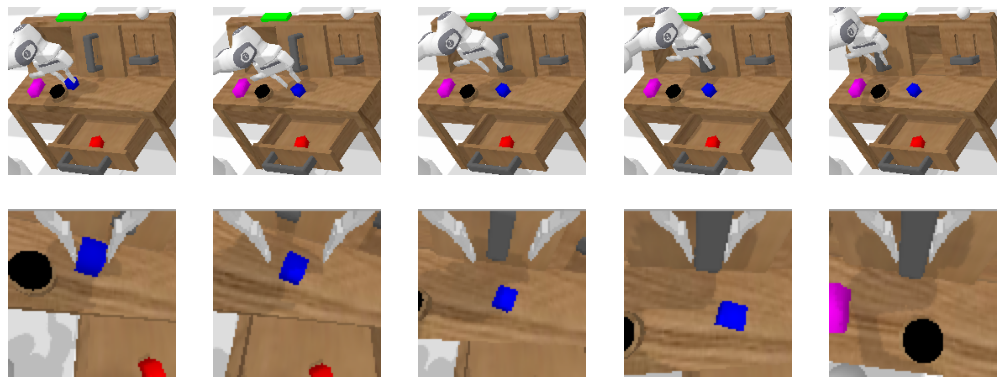

[('turn on the yellow lamp \n', tensor(0.8656, device='cuda:0')), ('move the light switch to turn on the yellow light \n', tensor(0.8357, device='cuda:0')), ('move the light switch to turn on the light bulb \n', tensor(0.8209, device='cuda:0')), ('toggle the light switch to turn on the yellow light \n', tensor(0.7883, device='cuda:0')), ('turn on the light bulb \n', tensor(0.7173, device='cuda:0'))]


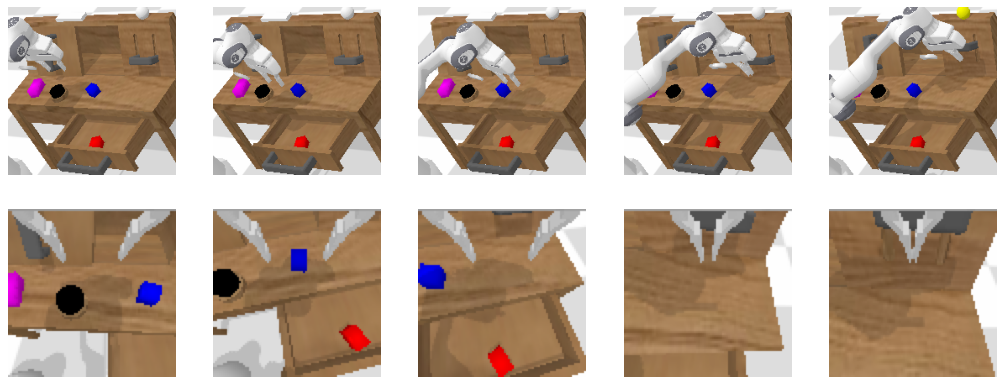

[('move the light switch to turn on the yellow light \n', tensor(0.8852, device='cuda:0')), ('move the light switch to turn on the light bulb \n', tensor(0.8580, device='cuda:0')), ('toggle the light switch to turn on the yellow light \n', tensor(0.7704, device='cuda:0')), ('turn on the yellow lamp \n', tensor(0.7512, device='cuda:0')), ('push the switch upwards \n', tensor(0.6976, device='cuda:0'))]


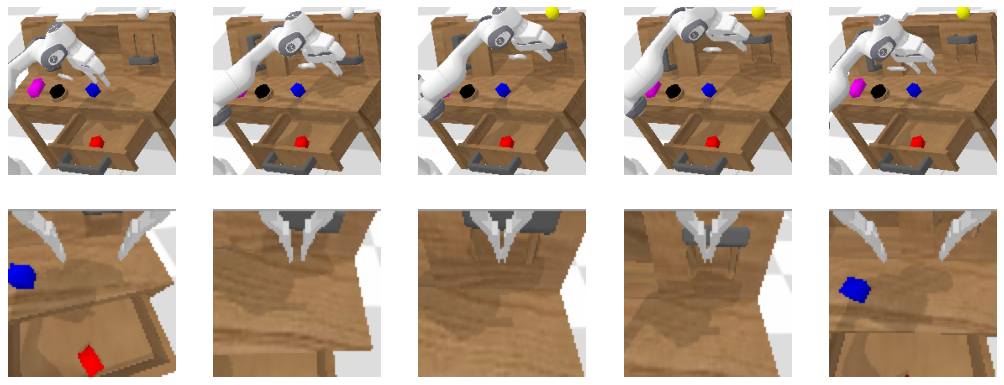

[(' rotate the pink block 90 degrees to the right \n', tensor(0.8809, device='cuda:0')), (' rotate the pink block towards the right \n', tensor(0.8212, device='cuda:0')), (' rotate the pink block to the right \n', tensor(0.7991, device='cuda:0')), (' turn the pink block right \n', tensor(0.7148, device='cuda:0')), (' pick up the pink block on the table \n', tensor(0.7047, device='cuda:0'))]


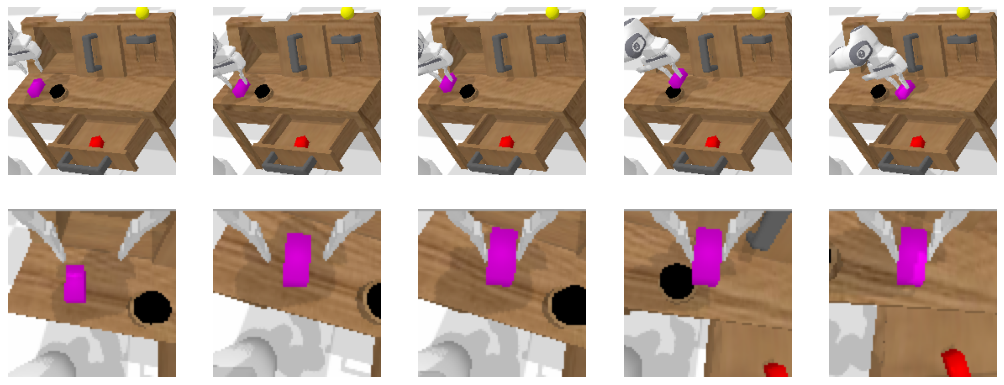

[('grasp the pink block on the table and lift it up \n', tensor(0.8586, device='cuda:0')), ('grasp the pink block on the table, then lift it up \n', tensor(0.8445, device='cuda:0')), ('move to the tower of blocks and take off the top one \n', tensor(0.8071, device='cuda:0')), ('grasp the pink block and lift it up \n', tensor(0.7203, device='cuda:0')), ('take off the stacked block \n', tensor(0.6998, device='cuda:0'))]


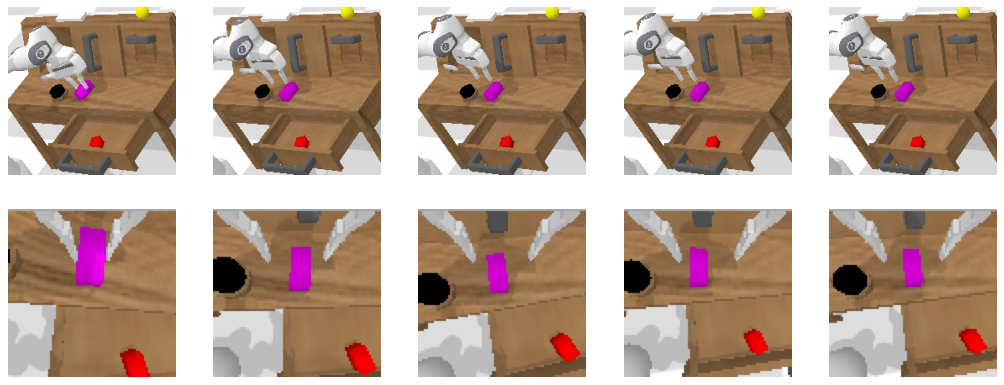

[('grasp the red block in the drawer \n', tensor(0.8606, device='cuda:0')), ('grasp the red block from the drawer \n', tensor(0.8441, device='cuda:0')), ('grasp the red block lying in the drawer \n', tensor(0.8222, device='cuda:0')), ('go towards the red block in the drawer and pick it up \n', tensor(0.8146, device='cuda:0')), ('go towards the red block in the drawer and lift it \n', tensor(0.7760, device='cuda:0'))]


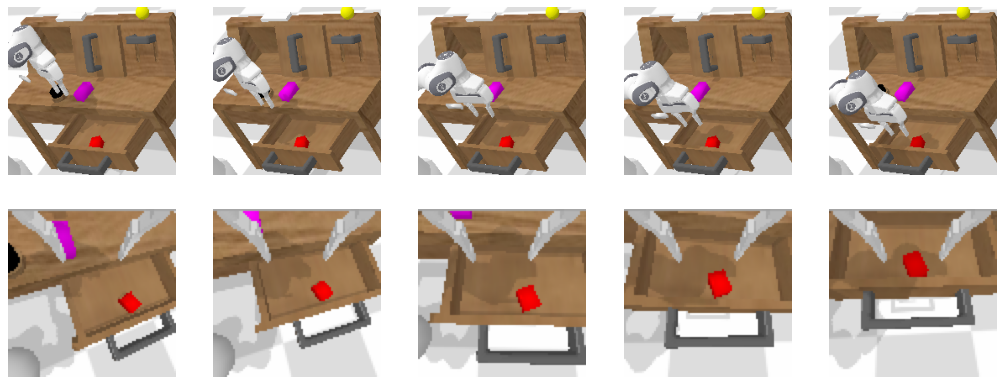

[('move the door all the way to the left and let go \n', tensor(0.9027, device='cuda:0')), ('grasp the door handle, then slide the door to the left \n', tensor(0.8423, device='cuda:0')), ('grasp the door handle and move the door to the left \n', tensor(0.8271, device='cuda:0')), ('move the door to the left side \n', tensor(0.7429, device='cuda:0')), ('push the door to the left \n', tensor(0.7306, device='cuda:0'))]


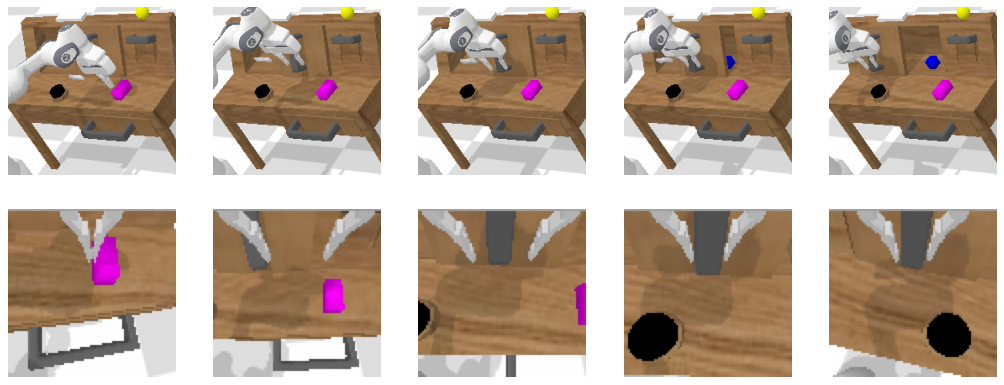

[('grasp the pink block on the table, then lift it up \n', tensor(0.8848, device='cuda:0')), ('grasp the pink block on the table and lift it up \n', tensor(0.8735, device='cuda:0')), ('grasp the pink block, then lift it up \n', tensor(0.8000, device='cuda:0')), ('grasp the pink block and lift it up \n', tensor(0.7942, device='cuda:0')), ('go to the tower of blocks and take off the top one \n', tensor(0.7821, device='cuda:0'))]


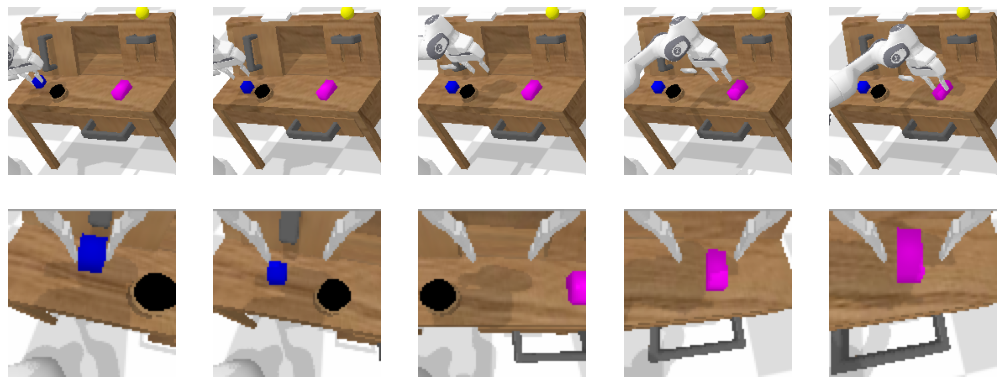

[('place the grasped block on top of another block \n', tensor(0.8692, device='cuda:0')), ('put the grasped block on top of a block \n', tensor(0.8199, device='cuda:0')), ('place the grasped object in the cabinet \n', tensor(0.7184, device='cuda:0')), ('place the grasped object in the drawer \n', tensor(0.7048, device='cuda:0')), ('place the block in the drawer \n', tensor(0.6779, device='cuda:0'))]


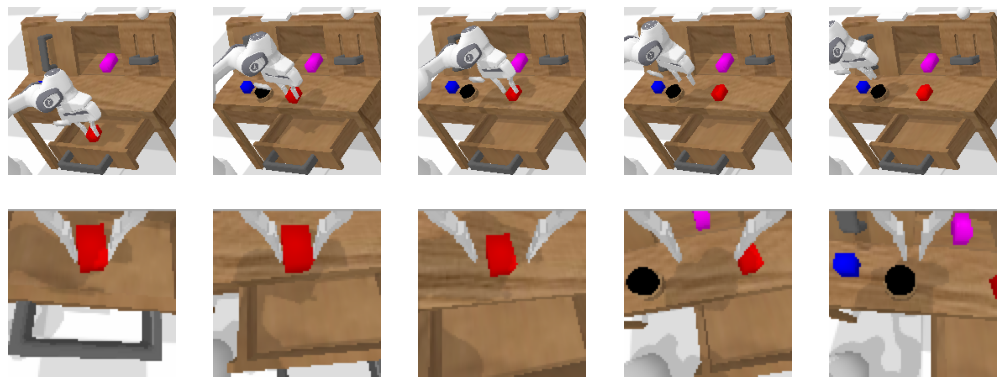

[('grasp the door handle and move the door to the right \n', tensor(0.8809, device='cuda:0')), ('move the door all the way to the right and let go \n', tensor(0.8653, device='cuda:0')), ('grasp the door handle, then slide the door to the right \n', tensor(0.8571, device='cuda:0')), ('grasp the door handle and slide the door to the right \n', tensor(0.8446, device='cuda:0')), ('grasp the door handle, then move the door to the right \n', tensor(0.8420, device='cuda:0'))]


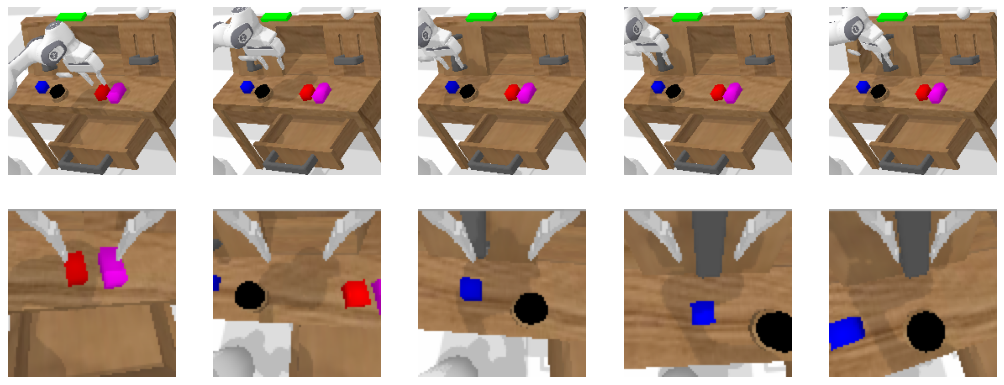

[('move the door all the way to the left and let go \n', tensor(0.9041, device='cuda:0')), ('slide the door to the left, then let it go \n', tensor(0.8365, device='cuda:0')), ('slide the door to the left side \n', tensor(0.7598, device='cuda:0')), ('move the door all the way to the left \n', tensor(0.7481, device='cuda:0')), ('move the door to the left side \n', tensor(0.7462, device='cuda:0'))]


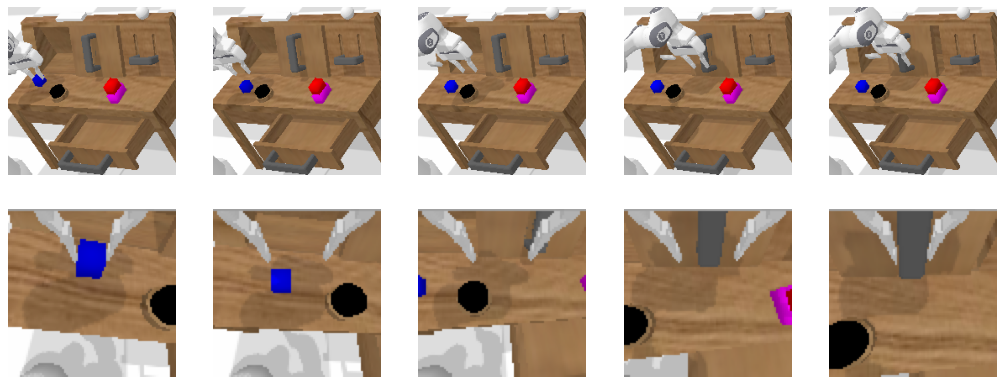

[('pick up the red block from the drawer \n', tensor(0.8507, device='cuda:0')), ('pick up the red block in the drawer \n', tensor(0.8126, device='cuda:0')), ('pick up the red block lying in the drawer \n', tensor(0.7755, device='cuda:0')), ('lift the red block in the drawer \n', tensor(0.7703, device='cuda:0')), (' pick up the red block from the drawer \n', tensor(0.7311, device='cuda:0'))]


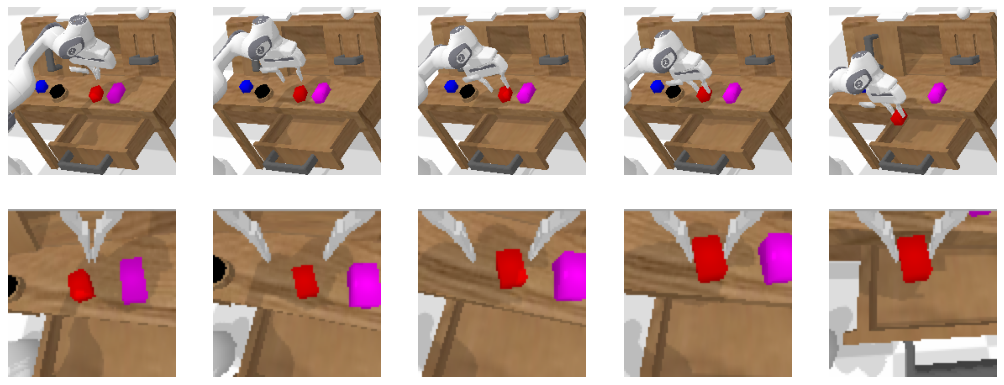

[('grasp the door handle and move the door to the right \n', tensor(0.8853, device='cuda:0')), ('grasp the door handle, then slide the door to the right \n', tensor(0.8548, device='cuda:0')), ('grasp the door handle and slide the door to the right \n', tensor(0.8511, device='cuda:0')), ('grasp the door handle, then move the door to the right \n', tensor(0.8490, device='cuda:0')), ('slide the door to the right, then let it go \n', tensor(0.8270, device='cuda:0'))]


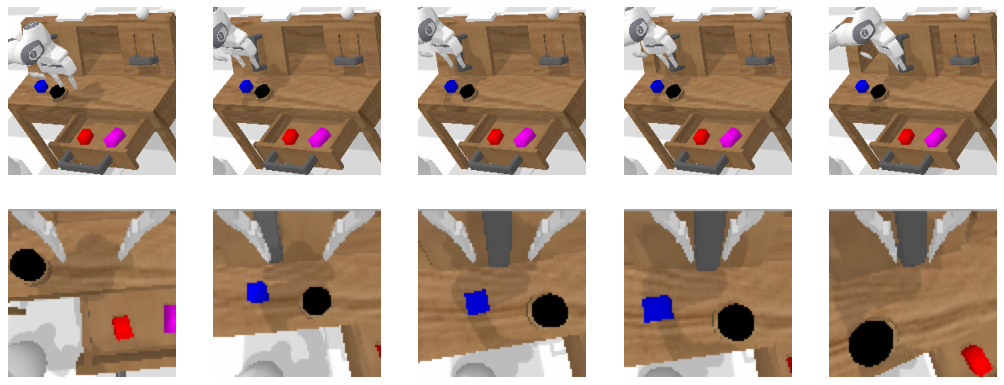

[('move the door all the way to the left and let go \n', tensor(0.8775, device='cuda:0')), ('slide the door to the left, then let it go \n', tensor(0.8620, device='cuda:0')), ('slide the door to the left side \n', tensor(0.8007, device='cuda:0')), ('move the door to the left side \n', tensor(0.7519, device='cuda:0')), ('slide the door to the left \n', tensor(0.7397, device='cuda:0'))]


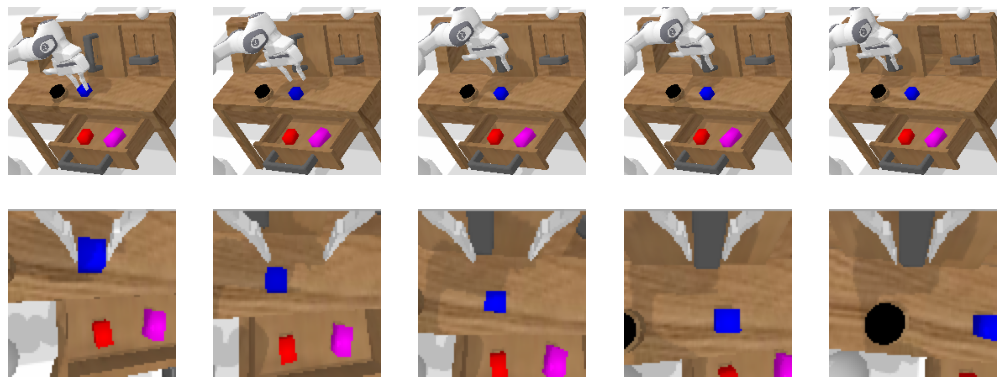

[('pick up the red block from the drawer \n', tensor(0.8720, device='cuda:0')), ('pick up the red block lying in the drawer \n', tensor(0.8669, device='cuda:0')), ('pick up the red block in the drawer \n', tensor(0.8559, device='cuda:0')), ('lift the red block lying in the drawer \n', tensor(0.7931, device='cuda:0')), ('lift the red block in the drawer \n', tensor(0.7766, device='cuda:0'))]


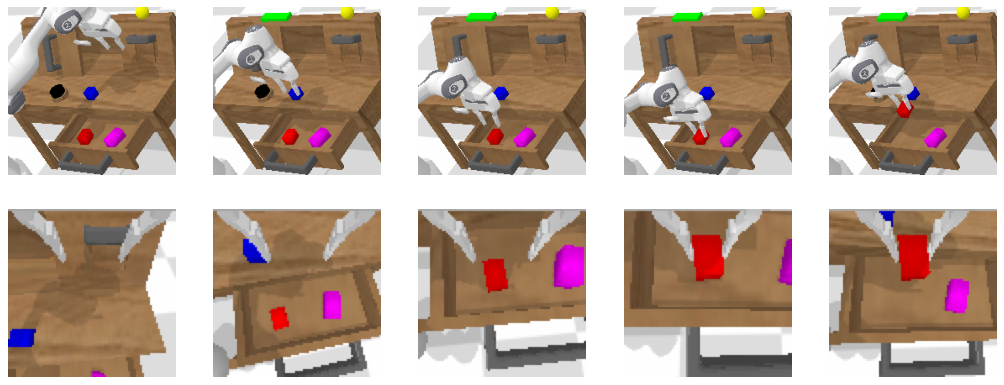

[('go towards the pink block in the drawer and pick it up \n', tensor(0.8679, device='cuda:0')), ('lift the pink block lying in the drawer \n', tensor(0.8240, device='cuda:0')), ('pick up the pink block lying in the drawer \n', tensor(0.7907, device='cuda:0')), ('pick up the pink block from the drawer \n', tensor(0.7893, device='cuda:0')), ('lift the pink block in the drawer \n', tensor(0.7679, device='cuda:0'))]


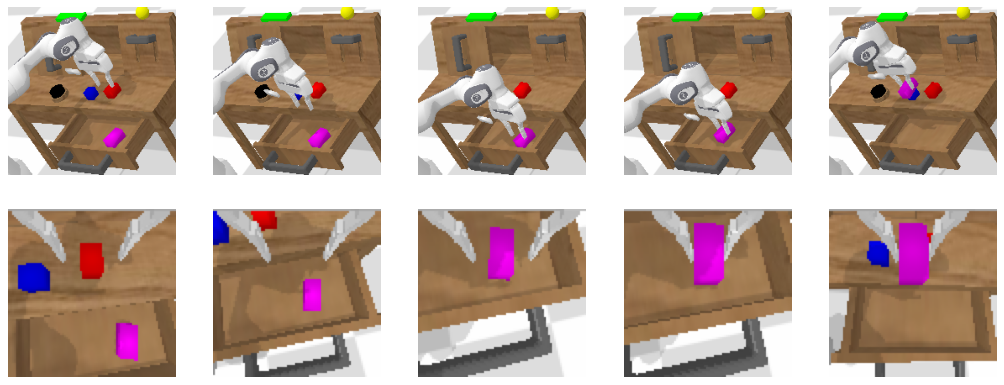

[(' in the slider pick up the pink block \n', tensor(0.8510, device='cuda:0')), (' in the cabinet pick up the pink block \n', tensor(0.7976, device='cuda:0')), ('in the slider pick up the pink block \n', tensor(0.7786, device='cuda:0')), (' in the slider grasp the pink block \n', tensor(0.7549, device='cuda:0')), ('grasp the pink block lying in the cabinet \n', tensor(0.7336, device='cuda:0'))]


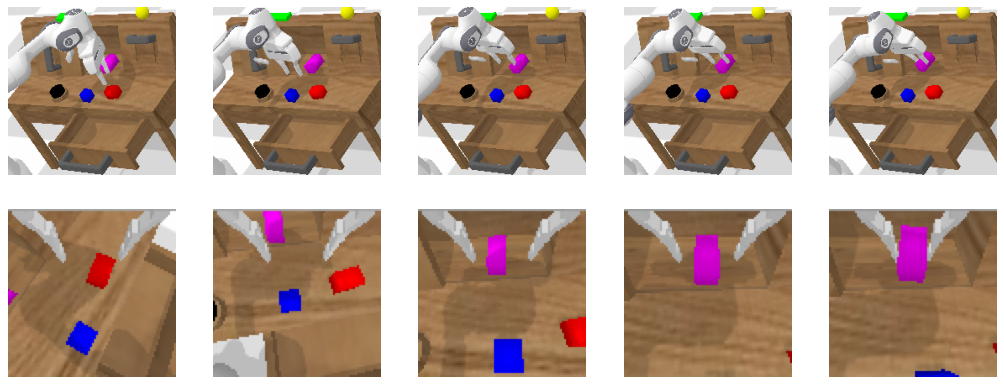

[('grasp the door handle and slide the door to the right \n', tensor(0.8682, device='cuda:0')), ('grasp the door handle and move the door to the right \n', tensor(0.8649, device='cuda:0')), ('grasp the door handle, then slide the door to the right \n', tensor(0.8591, device='cuda:0')), ('grasp the door handle, then move the door to the right \n', tensor(0.8491, device='cuda:0')), ('move the door all the way to the right and let go \n', tensor(0.8218, device='cuda:0'))]


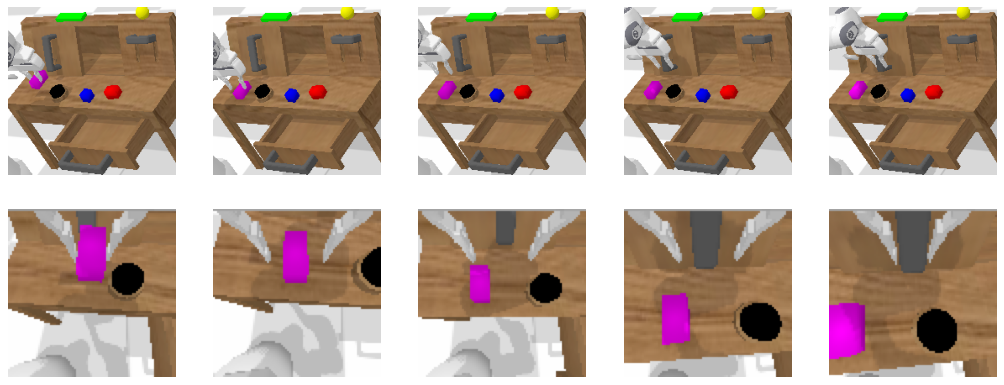

[('grasp the handle of the drawer, then close it \n', tensor(0.8913, device='cuda:0')), ('grasp the handle of the drawer and close it \n', tensor(0.8804, device='cuda:0')), ('grasp the drawer handle and close it \n', tensor(0.7899, device='cuda:0')), ('grasp the drawer handle, then close it \n', tensor(0.7644, device='cuda:0')), ('close the cabinet drawer \n', tensor(0.7374, device='cuda:0'))]


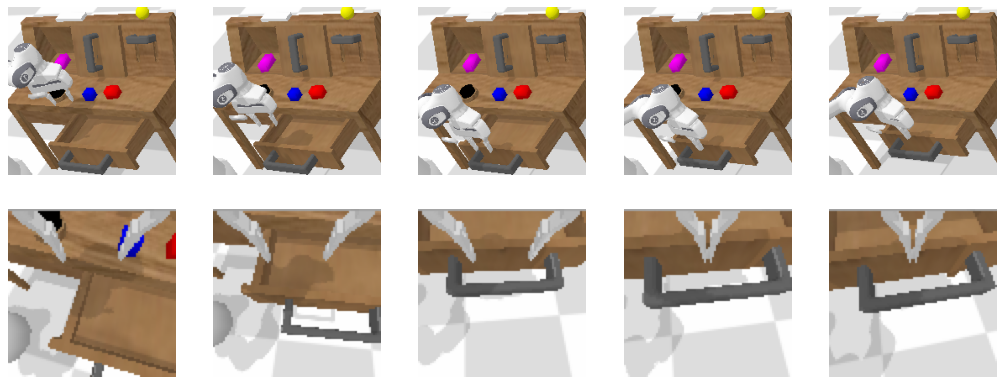

[('grasp the handle of the drawer, then close it \n', tensor(0.8707, device='cuda:0')), ('grasp the handle of the drawer and close it \n', tensor(0.8568, device='cuda:0')), ('grasp the drawer handle and close it \n', tensor(0.7659, device='cuda:0')), ('grasp the drawer handle, then close it \n', tensor(0.7515, device='cuda:0')), ('grasp the handle of the drawer and open it \n', tensor(0.7508, device='cuda:0'))]


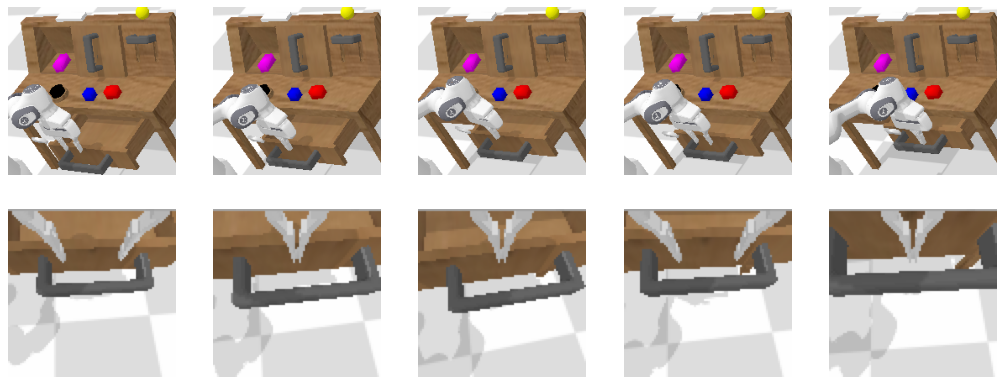

KeyboardInterrupt: 

In [17]:
#path_best = "./checkpoints/hulccap/run_1/hulccap_prefix-032.pt"
#path_best = "./checkpoints/hulccap/run2_with_stoptoken/hulccap_prefix-028.pt"
path_best = "./checkpoints/hulccap/run_4_rgb_gripper_and_static/hulccap_prefix-029.pt"

best_model = ClipCaptionModel(prefix_length=10, clip_length=10).to(CFG.device)
best_model.load_state_dict(torch.load(path_best, map_location=CFG.device))
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

data_path = CFG.datapath_training_parsed
window_size = 64
stride = 32
start_epi = 53819
end_epi = 60000
threshold =  0.85

for i in range(start_epi, end_epi, stride):
    if (i + window_size) < end_epi:
        actions = torch.zeros(64, 7) 
        observations = torch.zeros(64, 2048) 
        for idx, j in enumerate(range(i, i + window_size)):
            # print(idx, j)
            data = np.load(f"{data_path}/episode_{j:07d}.npz", allow_pickle=True)
            actions[idx] = torch.tensor(data['actions'])
            observations[idx] = torch.tensor(data['observations'])
        actions = actions.to(CFG.device)
        observations = observations.to(CFG.device)
        src = AttrDict(observations=observations.unsqueeze(0), actions=actions.unsqueeze(0))
        behaviour_encoding = best_model.behaviour_encoder(src)
        prefix_embed = best_model.project_to_gpt(behaviour_encoding)
        generated_caption =  beamsearch(best_model, tokenizer, prefix_embed)
        score = generated_caption[0][1].item()
        if score > threshold:
            print(generated_caption)
            print('index: ', i, ', ', i + window_size)
            showImages(i, CFG.datapath_training)

